In [1]:
import scipy.io
import scipy.stats
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from os import chdir
chdir('data/Cp_16_05_01')

In [3]:
import time as tm
def timing(f):
    def wrap(*args, **kwargs):
        time1 = tm.time()
        ret = f(*args, **kwargs)
        time2 = tm.time()
        print('{:s} function took {:07.3f} s'.format(f.__name__, (time2-time1)))

        return ret
    return wrap

## Préparation et visualisation des données

### Bases de données GPS et vitesse

In [4]:
#Téléchargement des données pour l'expérience 1 (qui sont sous forme de dictionnaire)
exp_ind = 1
gps = scipy.io.loadmat('juan{}_gps.mat'.format(exp_ind))
sensors = scipy.io.loadmat('juan{}_etc.mat'.format(exp_ind))

In [5]:
#Mise en forme en Data Frame
gps_df = pd.DataFrame(gps['GPS'], columns=gps['GPSFieldsOrder'])
sensors_df = pd.DataFrame(sensors['SENSORS'], columns=sensors['ETCFieldsOrder'])

In [6]:
#Changement du nom des variables
gps_df = pd.DataFrame(gps['GPS'], columns = ['time', 'ts', 'lat', 'long', 'alti', 'course', 'speedOG', 'speedV', 
                                              'SgmLat', 'SgmLong', 'SgmAlti', 'mode', 'sats'])
sensors_df = pd.DataFrame(sensors['SENSORS'], columns = ['time', 'counts', 'accel', 'steer', 'brake', 'speed'])

In [7]:
#Bien mettre en forme les données 

def readSensorData(sensors_df):
    '''Velocity and steering'''
    # Sensor params
    KV1 = 0.024970 * (1 - 0.21)
    KA1 = 0.00040 * (1 + 0)
    KA0 = 2022
    Kx1 = 1.0127
    Kx2 = 0.0042
    
    time_sensors = sensors_df['time'].values / 1000.
    steering = Kx1 * (sensors_df['steer'].values - KA0) * KA1 + Kx2 
    velocity = KV1 * sensors_df['speed'].values
    
    return time_sensors, steering, velocity


def readGPSData(gps_df):
    '''Latitude and longtitude'''
    # Reference point
    LAT0  = -33.8884
    LONG0 = 151.1948
    
    # Params
    a =  6378137.0
    b  = a * (1 - 0.003352810664747)
    kpi = np.pi / 180
    cf = np.cos(LAT0 * kpi)
    sf = np.abs(np.sin(LAT0 * kpi))
    Ro = a ** 2 * cf / np.abs(np.sqrt((a *cf) ** 2 + (b * sf) ** 2))  ;
    RR = b / a  * np.abs(np.sqrt(a ** 2- Ro ** 2)) / sf ;
    
    time_gps = gps_df['time'].values / 1000.
    latitude = - RR * kpi * (gps_df['lat'].values + LAT0)
    longtitude = Ro * kpi * (gps_df['long'].values - LONG0)
    
    return time_gps, latitude, longtitude

In [8]:
def scanData():
    '''
    Pour avoir le temps, le sensor et l'indice de chaque mesure qui arrive
    Au temps time[i] on a une mesure de sensor[i]
    (1 si gps, 2 si steering et velocity)
    dans l'indice index[i] du tableau correspondant
    '''
    time_sensors, steering, velocity = readSensorData(sensors_df)
    time_gps, latitude, longtitude = readGPSData(gps_df)
    
    times = [(1, i, time) for i, time in enumerate(time_gps)]
    times.extend([(2, i, time) for i, time in enumerate(time_sensors)])

    times = np.array(sorted(times, key=lambda u: u[2]))
    time, sensor, index = times[:, 2], times[:, 0], times[:, 1].astype(int)
    return time, sensor, index

In [9]:
#Construction des bases de données finales 
GPSData = pd.DataFrame(readGPSData(gps_df), ['times_GPS', 'latitude', 'longitude']).T
SensorData = pd.DataFrame(readSensorData(sensors_df), ['time_sensors', 'steering', 'velocity']).T

In [10]:
GPSData.head()

,times_GPS,latitude,longitude
0,851.227,-5.707890,6.615680
1,851.428,-5.709734,6.615680
2,851.628,-5.702355,6.614138
3,851.828,-5.700510,6.615680
4,852.028,-5.702355,6.615680


In [11]:
SensorData.head()

,time_sensors,steering,velocity
0,851.292,0.064557,0.0
1,851.317,0.064962,0.0
2,851.342,0.064557,0.0
3,851.367,0.064557,0.0
4,851.392,0.064557,0.0


## Quelques visualisations

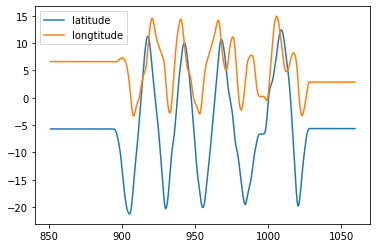

In [12]:
time_gps, latitude, longtitude = readGPSData(gps_df)
plt.plot(time_gps, latitude, label='latitude')
plt.plot(time_gps, longtitude, label='longtitude')
plt.legend()

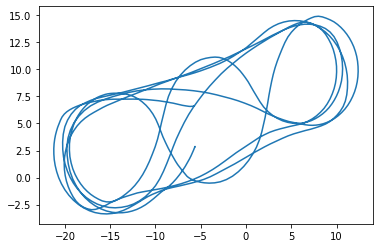

In [13]:
plt.plot(latitude, longtitude)

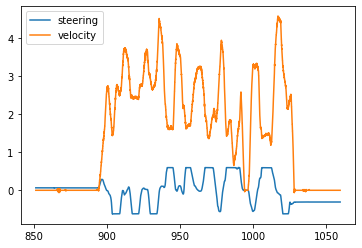

In [14]:
time_sensors, steering, velocity = readSensorData(sensors_df)
plt.plot(time_sensors, steering, label='steering')
plt.plot(time_sensors, velocity, label='velocity')
plt.legend()

### Quelques probas / générateurs aléatoires utiles:

In [15]:
from scipy.stats import dirichlet, multivariate_normal, beta, norm

In [16]:
# Paramètres pour le modèle de transition (partie bruit)
timestep = (time_sensors[-1] - time_sensors[0]) / (len(time_sensors) - 1)
noise_measures = np.zeros((len(time_sensors) - 2, 2))
# Dérivée de la vitesse
noise_measures[:, 0] = (velocity[1:-1] - velocity[:-2]) / timestep
# Dérivée seconde de beta
noise_measures[:, 1] = (steering[2:] - 2 * steering[1:-1] + steering[:-2]) / (timestep ** 2)

#Covariance comme espérance
noise_cov = noise_measures.T @ noise_measures / (len(time_sensors) - 2)
noise_mean = np.zeros(2)

var_gps = 0.002
S = var_gps * np.eye(2)

p0_z1 = lambda u: 1e-3 # Uniforme sur un grand intervalle
# Etat de "mauvais" fonctionnement du gps

# Algorithme du filtre particulaire classique

In [17]:
def initilisation_pf(N): #on initialise avec des uniformes sur les espaces de vie des variables
    stretch = 1.02
    
    x_min, x_max = np.min(stretch * latitude), np.max(stretch * latitude)
    y_min, y_max = np.min(stretch * longtitude), np.max(stretch * longtitude)
    v_max = np.max(stretch * velocity)
    beta_min, beta_max = np.min(stretch * steering), np.max(stretch * steering)
    beta_dot = (steering[1:] - steering[:-1]) / (time_sensors[1:] - time_sensors[:-1])
    beta_dot_min, beta_dot_max = np.min(stretch * beta_dot), np.max(stretch * beta_dot)
    
    init_state = {
        'x': np.random.uniform(low=x_min, high=x_max, size=N),
        'y': np.random.uniform(low=y_min, high=y_max, size=N),
        'v': np.random.uniform(low=0, high=v_max, size=N),
        'psi': np.random.uniform(low=0, high=2*np.pi, size=N),
        'beta': np.random.uniform(low=beta_min, high=beta_max, size=N),
        'beta_dot': np.random.uniform(low=beta_dot_min, high=beta_dot_max, size=N)
    }
    init_gps_state = {
        'sigma': np.exp(np.random.normal(0, 1, size=N)), 
        'alpha': np.ones((N, 2)) / 2 ,
        'c': np.zeros(N), # tous les gps marchent bien a priori
    }
    init_poids = np.ones(N) / N
    
    return init_state, init_gps_state, init_poids 


# Geometric constants
L = 2.83
H = 0.76
a = 3.78
b = 0.5

# Modèle de transtion pour l’état suivant des particules avec un bruit aléatoire
def transition_model(current_state, dt, with_noise=True):
    '''return the state transition model taking into
    account he state noise (v' and beta'')'''
    # Retrieve initial states
    x = current_state['x']
    y = current_state['y']
    v = current_state['v']

    psi = current_state['psi']
    beta = current_state['beta']
    beta_dot = current_state['beta_dot']
    
    # Next states
    next_state = dict()
    next_state['x'] = x + dt * v * (np.cos(psi) + (- a * np.sin(psi) + b * np.cos(psi)) * np.tan(beta) / L)
    next_state['y'] = y + dt * v * (np.sin(psi) + (a * np.cos(psi) + b * np.sin(psi)) * np.tan(beta) / L)
    next_state['v'] = v
    
    next_state['psi'] = psi + dt * v * np.tan(beta) / L
    next_state['beta'] = beta + dt * beta_dot
    next_state['beta_dot'] = beta_dot
    
    if with_noise:
        state_noise = np.random.multivariate_normal(noise_mean, noise_cov, size=x.shape[0])
        next_state['v'] += dt * state_noise[:, 0]
        next_state['beta_dot'] += dt * state_noise[:, 1]

    return next_state


# Mise à jour des poids selon les mesures qui arrivent
def update_model(N, weights, update_GPS, measures, particles):    
    log_weights = np.log(weights)
    #Cas GPS
    if update_GPS:
        erreur_mesure_h1 = np.linalg.norm([particles['x'] - measures['x'],
                                           particles['y'] - measures['y']], axis = 0)
        
        log_weights += norm(0, 2).logpdf(erreur_mesure_h1)


    #Cas sensors   
    else:
        # h3(x_t) = beta_t
        erreur_mesure_h3 = ((particles['beta'] - measures['beta']) + np.pi) % (2 * np.pi) - np.pi
        # h2(x_t) = (1 + tan(beta_t)) * v_t
        erreur_mesure_h2 = (1 + np.tan(particles['beta']) * H / L) * particles['v'] - measures['v']
        
        log_weights += (
            norm(0, 0.1).logpdf(erreur_mesure_h2)
            + norm(0, 0.02).logpdf(erreur_mesure_h3)
        )

    log_weights -= np.max(log_weights)
    weights = np.exp(log_weights)
    weights /= sum(weights) # normalize
    
    return weights

# Fonction pour un resampling aléatoire
def resample(N, particles, weights):
    index_particles_alive = np.random.choice(N, size=N, p=weights)
    new_particles = {key: particles[key][index_particles_alive] for key in particles}
    return new_particles, np.ones(N) / N


# Fonction pour faire une estimation de l'état moyen des particules
def predictions(weights, particles):
    tab_predict = [sum(particles['x'] * weights), sum(particles['y'] * weights), sum(particles['v'] * weights), 
     sum(particles['beta'] * weights)]
    
    return tab_predict

In [18]:
def plot_particles(iii, particles, weights):
    plt.xlim(np.min(latitude), np.max(latitude))
    plt.ylim(np.min(longtitude), np.max(longtitude))
    
    rgba_colors = np.zeros((len(weights), 4))
    rgba_colors[:, 3] = weights / np.max(weights)
    
    ind_gps = iii
    ind_sensors = iii
    ind_gps_next = ind_gps + 1
    while sensor[ind_gps] == 2:
        ind_gps -= 1
    while sensor[ind_gps_next] == 2:
        ind_gps_next += 1
    while sensor[ind_sensors] == 1:
        ind_sensors -= 1
        
    x_psi = latitude[index[ind_gps_next]] - latitude[index[ind_gps]] 
    y_psi = longtitude[index[ind_gps_next]] - longtitude[index[ind_gps]] 
    psi = np.arctan2(y_psi, x_psi)
    dx = (np.max(velocity) + velocity[index[ind_sensors]]) * np.cos(psi + steering[index[ind_sensors]]) / 2
    dy = (np.max(velocity) + velocity[index[ind_sensors]]) * np.sin(psi + steering[index[ind_sensors]]) / 2
    
    plt.scatter(particles['x'], particles['y'], color=rgba_colors, s=0.1, label='Positions des particules')
    plt.plot(latitude[index[ind_gps]], longtitude[index[ind_gps]], 'o', label='Position mesurée')
    plt.arrow(latitude[index[ind_gps]], longtitude[index[ind_gps]], dx, dy, head_width=0.5, label='Direction mesurée')
    plt.legend()
    plt.savefig(f'{exp_ind}-{iii}.jpg')
    plt.clf()


In [19]:
#Définissons maintenant le corps de l'algo avec les différentes fonctions créées

@timing
def particle_filter(N, time, skip = 1, verbose = 10):
    
    #Liste à remplir
    list_predict = list()
    list_particles = list()
    list_weights = list()
    list_mesures = list()
    list_erreur = list()
    
    #Initialisation de l'algo
    particles, _, weights = initilisation_pf(N)
    t_previous = time[0]
    
    list_particles.append(particles)
    list_predict.append(predictions(weights, particles))
    list_weights.append(weights)
    
    for i in range(len(time)):
        if i % verbose == 0:
            print('iteration :', i)
#         if i % 50 == 0: 
#             plot_particles(i, particles, weights)
        if i % skip == 0:
            t = time[i] 
            # Sampling selon le modèle de transition
            particles = transition_model(particles, dt=(t-t_previous)/1000)

            update_GPS = sensor[i] == 1 # True si la i-eme mesure est celle du GPS   

            # Si on reçoit une mesure du GPS
            if update_GPS:
                measures = {'x': latitude[index[i]], 'y': longtitude[index[i]]}
                list_mesures.append([measures,i])

            # Si on reçoit une mesure du sensor
            else :
                measures = {'beta': steering[index[i]], 'v': velocity[index[i]]}

            weights = update_model(N, weights, update_GPS, measures, particles)

            # Resampling
            n_eff = 1 / np.sum(weights ** 2)

            if n_eff <= .8 * N:
                print('Resampled')
                particles, weights = resample(N, particles, weights)

            t_previous = t
            list_predict.append(predictions(weights, particles))

            if update_GPS:
                list_erreur.append(abs(predictions(weights, particles)[0] - latitude[index[i]]) + 
                                  abs(predictions(weights, particles)[1] - longtitude[index[i]]))

#             list_particles.append(particles)
#             list_weights.append(weights)
            
            
    return list_predict, list_particles, list_weights, list_mesures, list_erreur

# Application  avec notre filtre particulaire

In [20]:
#Le vecteur temps
time_sensors, steering, velocity = readSensorData(sensors_df)
time_gps, latitude, longtitude = readGPSData(gps_df)
time, sensor, index = scanData()
print(len(time))

9373


In [21]:
# Exécution de la fonction
list_predict, list_particles, list_weights, list_mesures, list_erreur = particle_filter(N=100000, skip=1, time=time)

iteration : 0
Resampled
Resampled
Resampled
Resampled
Resampled
iteration : 10
Resampled
Resampled
Resampled
iteration : 20
Resampled
iteration : 30
iteration : 40
iteration : 50
iteration : 60
Resampled
iteration : 70
Resampled
Resampled
iteration : 80
iteration : 90
iteration : 100
iteration : 110
iteration : 120
Resampled
Resampled
iteration : 130
Resampled
iteration : 140
iteration : 150
iteration : 160
iteration : 170
iteration : 180
iteration : 190
iteration : 200
iteration : 210
iteration : 220
iteration : 230
iteration : 240
Resampled
iteration : 250
iteration : 260
iteration : 270
iteration : 280
iteration : 290
iteration : 300
iteration : 310
iteration : 320
iteration : 330
iteration : 340
iteration : 350
iteration : 360
Resampled
Resampled
iteration : 370
Resampled
iteration : 380
iteration : 390
iteration : 400
Resampled
Resampled
Resampled
iteration : 410
Resampled
Resampled
iteration : 420
Resampled
Resampled
iteration : 430
iteration : 440
iteration : 450
iteration : 460

Resampled
iteration : 3740
Resampled
iteration : 3750
Resampled
iteration : 3760
Resampled
iteration : 3770
Resampled
Resampled
iteration : 3780
Resampled
iteration : 3790
Resampled
iteration : 3800
Resampled
iteration : 3810
Resampled
Resampled
iteration : 3820
Resampled
iteration : 3830
Resampled
iteration : 3840
Resampled
iteration : 3850
Resampled
Resampled
iteration : 3860
Resampled
iteration : 3870
Resampled
iteration : 3880
Resampled
Resampled
iteration : 3890
Resampled
iteration : 3900
Resampled
iteration : 3910
Resampled
iteration : 3920
Resampled
iteration : 3930
Resampled
iteration : 3940
Resampled
iteration : 3950
Resampled
iteration : 3960
Resampled
iteration : 3970
Resampled
iteration : 3980
iteration : 3990
Resampled
iteration : 4000
Resampled
iteration : 4010
Resampled
iteration : 4020
iteration : 4030
Resampled
iteration : 4040
Resampled
iteration : 4050
iteration : 4060
Resampled
iteration : 4070
Resampled
iteration : 4080
iteration : 4090
Resampled
iteration : 4100
R

Resampled
iteration : 7020
iteration : 7030
Resampled
iteration : 7040
iteration : 7050
Resampled
iteration : 7060
Resampled
iteration : 7070
iteration : 7080
Resampled
iteration : 7090
Resampled
iteration : 7100
iteration : 7110
Resampled
iteration : 7120
Resampled
iteration : 7130
iteration : 7140
Resampled
iteration : 7150
Resampled
iteration : 7160
Resampled
iteration : 7170
iteration : 7180
Resampled
iteration : 7190
Resampled
iteration : 7200
iteration : 7210
Resampled
iteration : 7220
iteration : 7230
Resampled
iteration : 7240
Resampled
iteration : 7250
iteration : 7260
Resampled
iteration : 7270
iteration : 7280
Resampled
iteration : 7290
Resampled
iteration : 7300
Resampled
iteration : 7310
Resampled
iteration : 7320
Resampled
iteration : 7330
Resampled
iteration : 7340
Resampled
iteration : 7350
Resampled
iteration : 7360
Resampled
iteration : 7370
Resampled
iteration : 7380
Resampled
Resampled
iteration : 7390
Resampled
iteration : 7400
Resampled
iteration : 7410
Resampled


Text(0.5, 1.0, 'Mesures du GPS')

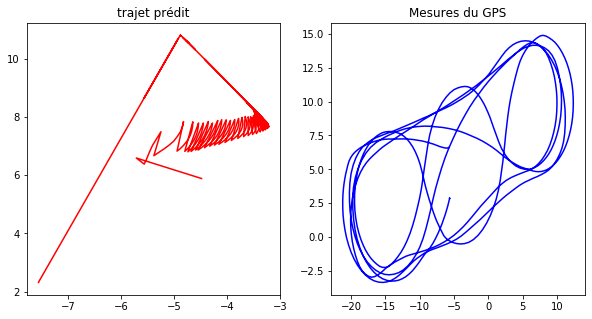

In [24]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.plot(np.array(list_predict)[:,0], np.array(list_predict)[:,1], 'red')
plt.title('trajet prédit')

plt.subplot(1,2,2)
plt.plot(latitude, longtitude, 'blue')
plt.title('Mesures du GPS')
#xmin, xmax, ymin, ymax = plt.axis([-5.72,-5.68,-3, 15])

In [27]:
erreur = list()

for ite in range(10):
    _,_,_, _, list_erreur = particle_filter(N=10000, time=time, verbose=1000)
    erreur.append(sum(list_erreur) / len(time))
    
print(f'erreur moyenne de {np.mean(erreur):06} ± {np.std(erreur):06}')

iteration : 0
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
iteration : 1000
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
iteration : 2000
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Re

Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
iteration : 6000
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Res

Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
iteration : 3000
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Res

Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
iteration : 7000
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Res

/home/elyes/.local/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log


Resampled
Resampled
iteration : 1000
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
iteration : 2000
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
iteration : 3000

Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
iteration : 6000
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Res

Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
iteration : 3000
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Res

Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
iteration : 6000
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
iteration : 7000
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resamp

# Algorithme Rao-Blackwell UKF

In [28]:
# !pip3 install filterpy

In [29]:
from filterpy.kalman import UnscentedKalmanFilter, MerweScaledSigmaPoints

In [30]:
def resample_vectoriel(N, particles, gps_states, weights):
    index_particles_alive = np.random.choice(N, size=N, p=weights)
    gps_states = {key: gps_states[key][index_particles_alive] for key in gps_states}
    return particles[index_particles_alive], gps_states, np.ones(N) / N

In [31]:
def initilisation_pf_vectoriel(N):
    
    stretch = 1.02
    
    x_min, x_max = np.min(stretch * latitude), np.max(stretch * latitude)
    y_min, y_max = np.min(stretch * longtitude), np.max(stretch * longtitude)
    v_max = np.max(stretch * velocity)
    beta_min, beta_max = np.min(stretch * steering), np.max(stretch * steering)
    beta_dot = (steering[1:] - steering[:-1]) / (time_sensors[1:] - time_sensors[:-1])
    beta_dot_min, beta_dot_max = np.min(stretch * beta_dot), np.max(beta_dot)
    
    init_state = np.zeros((N, 6))
    # x
    init_state[:, 0] = np.random.uniform(low = x_min, high = x_max, size = N)
    # y
    init_state[:, 1] = np.random.uniform(low = y_min, high = y_max, size = N)
    # v
    init_state[:, 2] = np.random.uniform(low = 0, high = v_max, size = N)
    # psi
    init_state[:, 3] = np.random.uniform(low = 0, high = 2*np.pi, size = N)
    # beta
    init_state[:, 4] = np.random.uniform(low = beta_min, high = beta_max, size = N)
    # beta_point
    init_state[:, 5] = np.random.uniform(low = beta_dot_min, high = beta_dot_max, size = N)

    init_gps_state = {
        'sigma': np.exp(np.random.normal(0, 1, size = N)),
        'alpha': np.ones((N, 2)) / 2 ,
        'c': np.zeros(N), # tous les gps marchent bien a priori
    }
    
    init_uncertainty_matrices = [np.eye(6) for _ in range(N)]
    init_poids = np.ones(N) / N
    
    return init_state, init_gps_state, init_uncertainty_matrices, init_poids

In [32]:
def transition_model_vectoriel(current_state, dt):
    
    ''' return the state transition model WITHOUT taking into
    account the state noise (v' and beta'') '''
    
    # Retrieve initial states
    x = current_state[0]
    y = current_state[1]
    v = current_state[2]

    psi = current_state[3]
    beta = current_state[4]
    beta_dot = current_state[5]
    
    # Next states
    next_state = np.zeros(6)
    next_state[0] = x + dt * v * (np.cos(psi) + (- a * np.sin(psi) + b * np.cos(psi)) * np.tan(beta) / L)
    next_state[1] = y + dt * v * (np.sin(psi) + (a * np.cos(psi) + b * np.sin(psi)) * np.tan(beta) / L)
    next_state[2] = v
    
    next_state[3] = psi + dt * v * np.tan(beta) / L
    next_state[4] = beta + dt * beta_dot
    next_state[5] = beta_dot

    return next_state

In [33]:
# Fonction pour sampler l’état suivant du GPS
def update_gps_states_vectoriel(N, gps_states, particles, measures):
    gps_states_new = dict()
    gps_states_new['c'], gps_states_new['c_proba'] = np.zeros(N), np.zeros(N)
    gps_states_new['alpha'], gps_states_new['alpha_proba'] = np.zeros((N, 2)), np.zeros(N)
    gps_states_new['sigma'], gps_states_new['sigma_proba'] = np.zeros(N), np.zeros(N)
    
    alpha = gps_states['alpha']
    sigma = gps_states['sigma']
    
    for i in range(N):
        ''' === ÉQUATION 29 page 11 ===
        Mise à jour de c '''
        z1 = [particles[i, 0], particles[i, 1]]
        h_x_1 = [measures['x'], measures['y']]
        
        p_c_0 = alpha[i][0] * p0_z1(z1) / (alpha[i][0] *  p0_z1(z1) 
                                           + alpha[i][1] * multivariate_normal.pdf(z1, h_x_1, S))

        sampled = np.random.binomial(1, p_c_0)

        gps_states_new['c'][i] = sampled
        gps_states_new['c_proba'][i] = p_c_0 if sampled == 0 else 1 - p_c_0
        
    for i in range(N):
        ''' === ÉQUATION 26 page 11 ===
        Mise à jour d'alpha '''
        params = sigma[i] * alpha[i] + (gps_states_new['c'][i] == 0)
        rv = beta(params[0], params[1])
        try:
            sampled = rv.rvs()
        except:
#             print(params, sigma[i], alpha[i])
            pass
        proba = rv.pdf(sampled)
        
        gps_states_new['alpha'][i] = (sampled, 1 - sampled)
        gps_states_new['alpha_proba'][i] = proba
        
    rv = scipy.stats.norm(0, 1)
    for i in range(N):
        ''' === ÉQUATION 28 page 11 ===
        Mise à jour de sigma '''
        sampled = rv.rvs()
        gps_states_new['sigma'][i] = gps_states['sigma'][i] * np.exp(sampled)
        gps_states_new['sigma_proba'][i] = rv.pdf(sampled)

    return gps_states_new

In [34]:
sigma_points = MerweScaledSigmaPoints(6, alpha=.1, beta=2., kappa=-1)

h1 = lambda state: [state[0], state[1]] # mesures de x et y
h23 = lambda state: [(1 + np.tan(state[2]) * H / L) * state[4], state[4]] # mesures de v et beta

var_gps = 0.002
var_sensors_mat = np.diag([0.1, 0.002])

def update_particles_ukf(N, dt, update_GPS, measures, particles, uncertainty_matrices, gps_states): 
    '''Met a jour l'etat des particules + matrices de cov des estimations
    avec un UKF'''
    new_particles = np.zeros((N, 6))
    new_uncertainty_matrices = list()
    if update_GPS:
        ukf_gps = UnscentedKalmanFilter(dim_x=6, dim_z=2, dt=dt, fx=transition_model_vectoriel, hx=h1, points=sigma_points)
        for i in range(N):
            ukf_gps.x = particles[i] # Etat estime de la particule
            ukf_gps.P = uncertainty_matrices[i] # matrice de covariance de l'estimation
            
            if gps_states['c'][i] == 0: # Fonctionnement nominal
                ukf_gps.R = var_gps * np.eye(2)
            else: # Mauvais fonctionnement, grosse incertitude 
                ukf_gps.R = 40 * var_gps * np.eye(2)
            
            ukf_gps.predict()
            ukf_gps.update(measures)
            new_particles[i] = ukf_gps.x
            new_uncertainty_matrices.append(ukf_gps.P)

    else:
        ukf_sensors = UnscentedKalmanFilter(dim_x=6, dim_z=2, dt=dt, fx=transition_model_vectoriel, hx=h23, points=sigma_points)
        ukf_sensors.R = var_sensors_mat
        for i in range(N):
            ukf_sensors.x = particles[i] # Etat estime de la particule
            ukf_sensors.P = uncertainty_matrices[i] # matrice de covariance de l'estimation
            
            # Etape predict et update
            ukf_sensors.predict()
            ukf_sensors.update(measures)
            
            new_particles[i] = ukf_sensors.x
            new_uncertainty_matrices.append(ukf_sensors.P)
    return new_particles, uncertainty_matrices

In [35]:
def update_model_vectoriel(N, weights, update_GPS, measures, particles, gps_state): 
    '''Met a jour les poids des particules'''
    log_weights = np.log(weights)
    # == Cas GPS
    if update_GPS:
        erreur_mesure = np.linalg.norm([particles[:, 0] - measures['x'],
                                        particles[:, 1] - measures['y']], axis = 0)
        c, c_proba = gps_state['c'], gps_state['c_proba']

        # mise à jour des poids
        log_c_0 = norm(0, 0.2).logpdf(erreur_mesure)
        log_c_1 = norm(0, 200).logpdf(erreur_mesure)
        log_weights += (c == 0) * log_c_0 + (c == 1) * log_c_1

    # == Cas sensors
    else:        
        # h3(x_t) = beta_t
        erreur_mesure_h3 = ((particles[:, 4] - measures['beta']) + np.pi) % (2 * np.pi) - np.pi
        # h2(x_t) = (1 + tan(beta_t)) * v_t
        erreur_mesure_h2 = (1 + np.tan(particles[:, 4]) * H / L) * particles[:, 2] - measures['v']

        log_weights += (
            norm(0, 0.1).logpdf(erreur_mesure_h2)
            + norm(0, 0.002).logpdf(erreur_mesure_h3)
        )
    
#     weights += 1e-300 # Eviter les divisions par 0
    weights = np.exp(log_weights - np.max(log_weights))
    weights /= sum(weights) # normalize  
        
    return weights

In [36]:
def predictions_vectoriel(weights, particles):
    
    tab_predict = [sum(particles[:, 0] * weights), sum(particles[:, 1] * weights), 
                   sum(particles[:, 2] * weights), sum(particles[:, 4] * weights)]
    
    return tab_predict

In [37]:
@timing
def rao_blackwell_filter(N = 10000, time = time, skip = 1, verbose = 10):
    
    #liste à remplir
    list_predict = list()
    list_particles = list()
    list_weights = list()
    list_mesures = list()
    list_erreur = list()
    
    # === Initialisation === #
    particles, gps_states, uncertainty_matrices, weights = initilisation_pf_vectoriel(N)
    t_previous = time[0] / 1000.

    # === Itérations === #
    for i in range(len(time)):
        
        if i % verbose == 0:
            print('iteration :', i)
            
        if i % skip == 0:
            t = time[i] / 1000.
            update_GPS = (sensor[i] == 1)

            # Si on reçoit une mesure du GPS
            if update_GPS:
                measures = {'x': latitude[index[i]], 'y': longtitude[index[i]]}
                measures_vect = [latitude[index[i]], longtitude[index[i]]]
                list_mesures.append([measures,i])

                # Update de c, alpha et sigma :
                gps_states = update_gps_states_vectoriel(N, gps_states, particles, measures)
                
                # Update de x chapeau et SIGMA avec UKF :
                particles, uncertainty_matrices = update_particles_ukf(N, t-t_previous, update_GPS, measures_vect,
                                                                       particles, uncertainty_matrices, gps_states)


            # Si on reçoit une mesure du sensor
            else:
                measures = {'beta': steering[index[i]], 'v': velocity[index[i]]}
                measures_vect = [steering[index[i]], velocity[index[i]]]
                
                # Update de x chapeau et SIGMA avec UKF :
                particles, uncertainty_matrices = update_particles_ukf(N, t-t_previous, update_GPS, measures_vect,
                                                                       particles, uncertainty_matrices, gps_states)

            # Update des poids :
            weights = update_model_vectoriel(N, weights, update_GPS, measures, particles, gps_states)

            # Resampling :
            Neff = 1. / sum(weights ** 2)
            if (Neff <= 0.8 * N) :
                print('Resampled')
                particles, gps_states, weights = resample_vectoriel(N, particles, gps_states, weights)

            t_previous = t
            list_predict.append(predictions_vectoriel(weights, particles))
            
            if update_GPS:
                list_erreur.append(abs(predictions_vectoriel(weights, particles)[0] - latitude[index[i]]) + 
                              abs(predictions_vectoriel(weights, particles)[1] - longtitude[index[i]]))
            
            list_particles.append(particles)
            list_weights.append(weights)
            
    return list_predict, list_particles, list_weights, list_mesures, list_erreur 

# Application du rao_blackwell_filter

Pour 100 unités de temps nous avons : 1040 mesures GPS


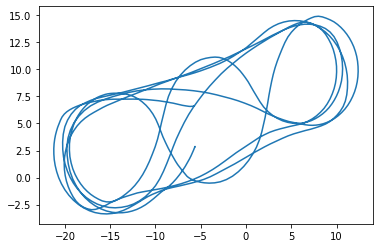

In [38]:
time_short = time[:]
list_longi = list()
list_lati = list()

for i in range(len(time_short)):

        update_GPS = sensor[i] == 1
        if update_GPS:
            list_lati.append(latitude[index[i]])
            list_longi.append(longtitude[index[i]])

print('Pour 100 unités de temps nous avons :', len(list_lati), 'mesures GPS')            
plt.plot(list_lati, list_longi)

#### We want to follow this trajectory

In [39]:
list_predict, list_particles, list_weights, list_mesures, list_erreur = rao_blackwell_filter(N = 1000, skip = 1, verbose = 10)

iteration : 0
Resampled
Resampled
iteration : 10
Resampled
Resampled
Resampled
iteration : 20
iteration : 30
Resampled
iteration : 40
iteration : 50
iteration : 60
iteration : 70
Resampled
iteration : 80
iteration : 90
iteration : 100
iteration : 110
Resampled
iteration : 120
iteration : 130
iteration : 140
iteration : 150
iteration : 160
iteration : 170
iteration : 180
Resampled
iteration : 190
iteration : 200
iteration : 210
iteration : 220
iteration : 230
iteration : 240
iteration : 250
iteration : 260
iteration : 270
iteration : 280
iteration : 290
iteration : 300
iteration : 310
iteration : 320
iteration : 330
iteration : 340
iteration : 350
iteration : 360
iteration : 370
iteration : 380
iteration : 390
iteration : 400
iteration : 410
iteration : 420
iteration : 430
iteration : 440
iteration : 450
iteration : 460
iteration : 470
iteration : 480
iteration : 490
iteration : 500
iteration : 510
iteration : 520
iteration : 530
iteration : 540
iteration : 550
iteration : 560
iteration

/home/elyes/.local/lib/python3.6/site-packages/scipy/stats/_continuous_distns.py:520: RuntimeWarning: overflow encountered in exp
  return np.exp(self._logpdf(x, a, b))


iteration : 1200
iteration : 1210
iteration : 1220
iteration : 1230
iteration : 1240
iteration : 1250
iteration : 1260
iteration : 1270
iteration : 1280
iteration : 1290
iteration : 1300
iteration : 1310
iteration : 1320
iteration : 1330
iteration : 1340
iteration : 1350
iteration : 1360
iteration : 1370
iteration : 1380
iteration : 1390
iteration : 1400
iteration : 1410
iteration : 1420
iteration : 1430
iteration : 1440
iteration : 1450
iteration : 1460
iteration : 1470
iteration : 1480
iteration : 1490
iteration : 1500
iteration : 1510
iteration : 1520
iteration : 1530
iteration : 1540
iteration : 1550
iteration : 1560
iteration : 1570
iteration : 1580
iteration : 1590
iteration : 1600
iteration : 1610
iteration : 1620
iteration : 1630
iteration : 1640
iteration : 1650
iteration : 1660
iteration : 1670
iteration : 1680
iteration : 1690
iteration : 1700
iteration : 1710
iteration : 1720
iteration : 1730
iteration : 1740
iteration : 1750
iteration : 1760
iteration : 1770
iteration : 17

iteration : 4970
iteration : 4980
Resampled
iteration : 4990
Resampled
iteration : 5000
iteration : 5010
Resampled
iteration : 5020
iteration : 5030
Resampled
iteration : 5040
iteration : 5050
Resampled
iteration : 5060
iteration : 5070
Resampled
iteration : 5080
Resampled
iteration : 5090
iteration : 5100
Resampled
iteration : 5110
iteration : 5120
Resampled
iteration : 5130
iteration : 5140
Resampled
iteration : 5150
iteration : 5160
Resampled
iteration : 5170
Resampled
iteration : 5180
iteration : 5190
Resampled
iteration : 5200
iteration : 5210
Resampled
iteration : 5220
iteration : 5230
Resampled
iteration : 5240
iteration : 5250
Resampled
iteration : 5260
Resampled
iteration : 5270
iteration : 5280
Resampled
iteration : 5290
iteration : 5300
Resampled
iteration : 5310
iteration : 5320
Resampled
iteration : 5330
iteration : 5340
Resampled
iteration : 5350
Resampled
iteration : 5360
iteration : 5370
Resampled
iteration : 5380
iteration : 5390
Resampled
iteration : 5400
iteration : 

iteration : 8780
iteration : 8790
iteration : 8800
iteration : 8810
iteration : 8820
iteration : 8830
iteration : 8840
iteration : 8850
iteration : 8860
iteration : 8870
iteration : 8880
iteration : 8890
iteration : 8900
iteration : 8910
iteration : 8920
iteration : 8930
iteration : 8940
iteration : 8950
iteration : 8960
iteration : 8970
iteration : 8980
iteration : 8990
iteration : 9000
iteration : 9010
iteration : 9020
iteration : 9030
iteration : 9040
iteration : 9050
iteration : 9060
iteration : 9070
iteration : 9080
iteration : 9090
iteration : 9100
iteration : 9110
iteration : 9120
iteration : 9130
iteration : 9140
iteration : 9150
iteration : 9160
iteration : 9170
iteration : 9180
iteration : 9190
iteration : 9200
iteration : 9210
iteration : 9220
iteration : 9230
iteration : 9240
iteration : 9250
iteration : 9260
iteration : 9270
iteration : 9280
iteration : 9290
iteration : 9300
iteration : 9310
iteration : 9320
iteration : 9330
iteration : 9340
iteration : 9350
iteration : 93

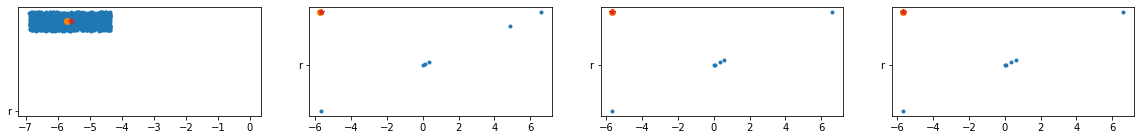

In [40]:
plt.figure(figsize=(20,2))

plt.subplot(1,4,1)
plt.plot(list_particles[0][:,0], list_particles[0][:,1],'.')
plt.plot(list_mesures[0][0]['x'], list_mesures[0][0]['y'], 'o', 'r')
plt.plot(list_predict[list_mesures[0][1]][0], list_predict[list_mesures[0][1]][1], '*')


plt.subplot(1,4,2)
plt.plot(list_particles[list_mesures[1][1]][0], list_particles[list_mesures[1][1]][1],'.')
plt.plot(list_mesures[1][0]['x'], list_mesures[1][0]['y'], 'o', 'r')
plt.plot(list_predict[list_mesures[1][1]][0], list_predict[list_mesures[1][1]][1], '*')


plt.subplot(1,4,3)
plt.plot(list_particles[list_mesures[2][1]][0], list_particles[list_mesures[2][1]][1],'.')
plt.plot(list_mesures[2][0]['x'], list_mesures[2][0]['y'], 'o', 'r')
plt.plot(list_predict[list_mesures[2][1]][0], list_predict[list_mesures[2][1]][1], '*')

plt.subplot(1,4,4)
plt.plot(list_particles[list_mesures[3][1]][0], list_particles[list_mesures[3][1]][1],'.')
plt.plot(list_mesures[3][0]['x'], list_mesures[3][0]['y'], 'o', 'r')
plt.plot(list_predict[list_mesures[3][1]][0], list_predict[list_mesures[3][1]][1], '*')

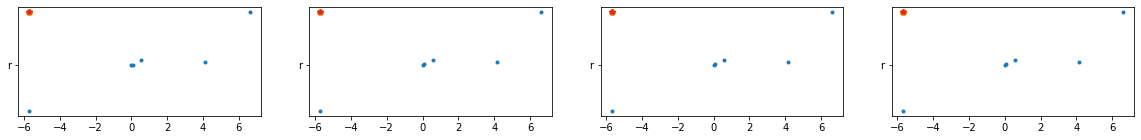

In [41]:
plt.figure(figsize=(20,2))

plt.subplot(1,4,1)
plt.plot(list_particles[list_mesures[5][1]][0], list_particles[list_mesures[5][1]][1],'.')
plt.plot(list_mesures[5][0]['x'], list_mesures[5][0]['y'], 'o', 'r')
plt.plot(list_predict[list_mesures[5][1]][0], list_predict[list_mesures[5][1]][1], '*')


plt.subplot(1,4,2)
plt.plot(list_particles[list_mesures[7][1]][0], list_particles[list_mesures[7][1]][1],'.')
plt.plot(list_mesures[7][0]['x'], list_mesures[7][0]['y'], 'o', 'r')
plt.plot(list_predict[list_mesures[7][1]][0], list_predict[list_mesures[7][1]][1], '*')


plt.subplot(1,4,3)
plt.plot(list_particles[list_mesures[9][1]][0], list_particles[list_mesures[9][1]][1],'.')
plt.plot(list_mesures[9][0]['x'], list_mesures[9][0]['y'], 'o', 'r')
plt.plot(list_predict[list_mesures[9][1]][0], list_predict[list_mesures[9][1]][1], '*')

plt.subplot(1,4,4)
plt.plot(list_particles[list_mesures[11][1]][0], list_particles[list_mesures[11][1]][1],'.')
plt.plot(list_mesures[11][0]['x'], list_mesures[11][0]['y'], 'o', 'r')
plt.plot(list_predict[list_mesures[11][1]][0], list_predict[list_mesures[11][1]][1], '*')

#### Plot du trajet prédit et du vrai trajet

Text(0.5, 1.0, 'Mesures GPS')

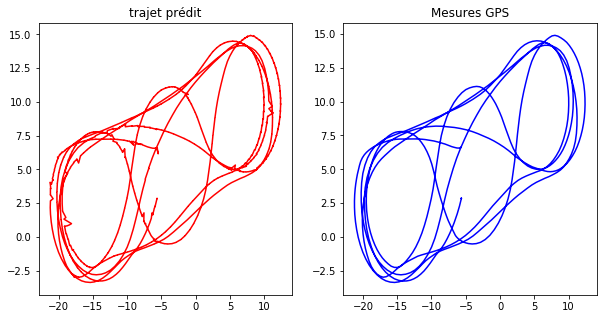

In [42]:
#Plot result
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.plot(np.array(list_predict)[:,0], np.array(list_predict)[:,1], 'red')
plt.title('trajet prédit')

plt.subplot(1,2,2)
plt.plot(list_lati, list_longi, 'blue')
plt.title('Mesures GPS')

In [43]:
erreur = list()

for ite in range(10):
    _,_,_, _, list_erreur = rao_blackwell_filter(N = 100, skip = 1, verbose = 1000)
    erreur.append(sum(list_erreur) / len(time))
    
print('erreur moyenne de ', np.mean(erreur),' + ou - ', np.std(erreur))

iteration : 0
Resampled
Resampled
iteration : 1000
iteration : 2000
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
iteration : 3000
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resam

/home/elyes/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


iteration : 2000
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
iteration : 3000
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resamp

Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
iteration : 5000
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Res

Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
iteration : 7000
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
iteration : 8000
iteration : 9000
rao_blackwell_filter function took 552.170 s
iteration : 0
Resampled
Resampled
iteration : 1000
iteration : 2000
Resampled
Resampled
Resampled
Resamp

Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
iteration : 3000
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
iteration : 4000
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resampled
Resamp

In [44]:
print('erreur moyenne de ', np.mean(erreur),' + ou - ', np.std(erreur))

erreur moyenne de  0.0019324950093423255  + ou -  1.6935070594184056e-05
